Imports for Python Machine Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


Load the Dataset

In [ ]:
df = pd.read_csv("/content/FinancialMarketDataEWS.csv")


In [ ]:
df

,Y,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,GT10,USGG2YR,USGG3M,US0001M,GTDEM30Y,GTDEM10Y,GTDEM2Y,EONIA,GTITL30YR,GTITL10YR,GTITL2YR,GTJPY30YR,GTJPY10YR,GTJPY2YR,GTGBP30Y,GTGBP20Y,GTGBP2Y,LUMSTRUU,LMBITR,LUACTRUU,LF98TRUU,LG30TRUU,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,0,1/11/2000,283.25,0.077,1388.0,157.2600,100.560,105.86,1.6460,25.77,22.50,6.6710,6.657,6.4280,5.4260,5.78100,6.121,5.541,4.316,2.890,6.321,5.777,4.495,2.422,1.709,0.346,4.5350,4.7700,6.5240,870.94,474.045,990.75,546.04,305.057,116.4640,230.527,123.7620,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,0,1/18/2000,287.65,0.043,1405.0,165.0100,101.860,105.47,1.6380,28.85,21.50,6.7470,6.748,6.4650,5.3780,5.80300,6.254,5.644,4.321,3.030,6.459,5.889,4.535,2.418,1.765,0.349,4.7460,4.9750,6.6130,869.33,473.223,990.48,545.68,305.303,117.2670,231.377,123.7620,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,0,1/25/2000,287.15,0.135,1368.0,167.2400,102.410,106.04,1.6500,28.28,23.02,6.6340,6.692,6.4320,5.5620,5.81900,6.045,5.515,4.270,3.150,6.281,5.760,4.511,2.259,1.625,0.293,4.6910,4.9000,6.5210,873.50,472.723,997.68,546.70,306.181,117.9950,232.390,123.7620,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,0,2/1/2000,282.75,0.191,1311.0,166.8500,104.920,107.85,1.6110,28.22,23.45,6.4230,6.619,6.5740,5.7080,5.88500,5.944,5.459,4.326,3.300,6.188,5.710,4.540,2.330,1.770,0.364,4.5930,4.7940,6.4670,871.22,473.255,997.91,547.38,305.997,120.5100,231.942,122.3280,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,1,2/8/2000,298.40,0.312,1277.0,165.4300,104.220,109.30,1.6110,28.02,21.25,6.2310,6.613,6.6780,5.6770,5.89100,5.850,5.482,4.390,3.260,6.118,5.728,4.638,2.481,1.919,0.359,4.5480,4.7680,6.4720,872.39,474.733,998.77,548.25,309.476,118.7910,237.812,122.3280,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,3/23/2021,1727.96,0.339,2271.0,184.5022,92.336,108.72,1.3760,57.76,20.30,2.3264,1.622,0.1452,0.0025,0.10738,0.228,-0.343,-0.716,-0.480,1.603,0.601,-0.415,0.621,0.077,-0.140,1.2864,1.2610,0.0401,2301.89,1330.717,3394.38,2346.07,1500.919,427.7972,1249.403,389.8500,3800.77,140.32,1199.57,1671.73,681.21,1695.96,110.83
1107,0,3/30/2021,1685.56,0.303,2103.0,184.8741,93.297,110.29,1.3719,60.55,19.61,2.3687,1.706,0.1465,0.0101,0.10850,0.265,-0.288,-0.698,-0.483,1.670,0.679,-0.382,0.648,0.085,-0.145,1.3580,1.3210,0.0686,2297.31,1333.400,3390.19,2352.95,1496.094,428.6578,1242.264,385.8145,3835.96,142.76,1206.29,1635.57,693.38,1690.76,108.80
1108,0,4/6/2021,1743.28,0.440,2092.0,185.8393,92.335,109.88,1.3822,59.33,18.12,2.3230,1.658,0.1566,0.0152,0.11038,0.233,-0.317,-0.706,-0.481,1.690,0.691,-0.377,0.678,0.108,-0.121,1.3353,1.2994,0.0699,2302.52,1335.609,3420.70,2370.97,1510.465,430.6649,1250.256,390.6819,3955.16,144.13,1194.62,1689.62,673.20,1689.48,111.92
1109,0,4/13/2021,1742.69,0.467,2140.0,188.1368,91.852,109.19,1.3737,60.18,16.65,2.2939,1.616,0.1589,0.0101,0.11225,0.262,-0.293,-0.707,-0.483,1.756,0.748,-0.363,0.667,0.101,-0.133,1.3053,1.2655,0.0436,2309.15,1341.393,3431.10,2371.86,1515.820,430.4087,1252.563,390.3848,4027.05,144.23,1197.06,1680.82,680.23,1672.46,108.40


In [ ]:
df.head()

,Y,Data,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,GT10,USGG2YR,USGG3M,US0001M,GTDEM30Y,GTDEM10Y,GTDEM2Y,EONIA,GTITL30YR,GTITL10YR,GTITL2YR,GTJPY30YR,GTJPY10YR,GTJPY2YR,GTGBP30Y,GTGBP20Y,GTGBP2Y,LUMSTRUU,LMBITR,LUACTRUU,LF98TRUU,LG30TRUU,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,0,1/11/2000,283.25,0.077,1388.0,157.26,100.56,105.86,1.646,25.77,22.50,6.671,6.657,6.428,5.426,5.781,6.121,5.541,4.316,2.89,6.321,5.777,4.495,2.422,1.709,0.346,4.535,4.770,6.524,870.94,474.045,990.75,546.04,305.057,116.464,230.527,123.762,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,0,1/18/2000,287.65,0.043,1405.0,165.01,101.86,105.47,1.638,28.85,21.50,6.747,6.748,6.465,5.378,5.803,6.254,5.644,4.321,3.03,6.459,5.889,4.535,2.418,1.765,0.349,4.746,4.975,6.613,869.33,473.223,990.48,545.68,305.303,117.267,231.377,123.762,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,0,1/25/2000,287.15,0.135,1368.0,167.24,102.41,106.04,1.650,28.28,23.02,6.634,6.692,6.432,5.562,5.819,6.045,5.515,4.270,3.15,6.281,5.760,4.511,2.259,1.625,0.293,4.691,4.900,6.521,873.50,472.723,997.68,546.70,306.181,117.995,232.390,123.762,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,0,2/1/2000,282.75,0.191,1311.0,166.85,104.92,107.85,1.611,28.22,23.45,6.423,6.619,6.574,5.708,5.885,5.944,5.459,4.326,3.30,6.188,5.710,4.540,2.330,1.770,0.364,4.593,4.794,6.467,871.22,473.255,997.91,547.38,305.997,120.510,231.942,122.328,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,1,2/8/2000,298.40,0.312,1277.0,165.43,104.22,109.30,1.611,28.02,21.25,6.231,6.613,6.678,5.677,5.891,5.850,5.482,4.390,3.26,6.118,5.728,4.638,2.481,1.919,0.359,4.548,4.768,6.472,872.39,474.733,998.77,548.25,309.476,118.791,237.812,122.328,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32


In [ ]:
df.describe()

,Y,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,GT10,USGG2YR,USGG3M,US0001M,GTDEM30Y,GTDEM10Y,GTDEM2Y,EONIA,GTITL30YR,GTITL10YR,GTITL2YR,GTJPY30YR,GTJPY10YR,GTJPY2YR,GTGBP30Y,GTGBP20Y,GTGBP2Y,LUMSTRUU,LMBITR,LUACTRUU,LF98TRUU,LG30TRUU,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
count,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000
mean,0.213321,987.463744,0.036153,2259.860486,245.247670,90.934982,106.605734,1.569661,60.708101,19.992169,3.908361,3.266748,1.990379,1.575180,1.836137,3.039282,2.448365,1.431110,1.363676,4.426725,3.680791,2.104911,1.724494,0.904126,0.150180,3.450157,3.445772,2.299772,1637.293510,883.615477,2077.306949,1231.258119,804.720667,232.109985,704.379545,259.052717,1606.997102,107.877138,784.846292,1903.216436,648.681377,693.156616,53.933159
std,0.409837,494.623740,0.349453,2017.811888,68.278066,11.379095,12.840754,0.212344,25.900813,8.642157,1.178584,1.332464,1.710305,1.802895,1.909024,1.779526,1.851558,1.876061,1.721894,1.274729,1.465289,1.700726,0.720026,0.643985,0.297519,1.263211,1.366181,2.128524,417.229338,241.507115,690.731794,553.121000,370.251989,109.917628,309.951757,75.934451,698.481956,20.795973,200.076443,986.468254,299.096020,405.527014,24.738356
min,0.000000,256.680000,-0.974000,291.000000,106.293000,71.329000,75.940000,1.172000,10.010000,9.430000,1.163000,0.508000,0.107300,-0.038000,0.105750,-0.471000,-0.794000,-0.968000,-0.498000,1.386000,0.512000,-0.458000,0.056000,-0.291000,-0.351000,0.547000,0.489200,-0.163300,869.330000,472.723000,986.940000,491.080000,294.367000,80.797000,230.527000,121.331000,663.690000,56.300000,431.710000,280.500000,151.250000,112.600000,13.460000
25%,0.000000,433.740000,-0.191000,990.000000,184.705550,81.240500,101.565000,1.418000,39.625000,13.640000,2.960000,2.195500,0.576000,0.090000,0.241000,1.288000,0.539000,-0.382500,-0.229500,3.395000,2.329500,0.403500,1.055000,0.253500,-0.031000,2.336000,2.185000,0.466000,1251.130000,683.896500,1509.730000,743.535000,479.388500,131.025000,434.661000,205.315500,1103.925000,90.605000,601.615000,1042.645000,463.195000,278.385000,28.565000
50%,0.000000,1137.800000,0.035000,1518.000000,234.560000,89.716000,108.720000,1.562000,57.400000,17.980000,4.100000,3.115000,1.522000,0.958000,1.214000,3.572000,2.994000,1.057000,0.437000,4.839000,4.098000,2.214000,1.944000,1.038000,0.097000,4.112000,4.114000,0.936000,1723.800000,855.517000,2045.550000,1145.150000,765.248000,213.205000,714.807000,264.770000,1324.430000,111.320000,786.830000,1860.960000,612.930000,691.530000,58.740000
75%,0.000000,1324.825000,0.260500,2685.500000,301.539500,97.404000,116.220000,1.677500,79.640000,23.625000,4.844500,4.345000,2.927500,2.335500,2.502500,4.582500,4.080000,3.121000,2.890000,5.312500,4.683500,3.523000,2.315500,1.429500,0.230000,4.486000,4.611000,4.488000,2005.330000,1099.705500,2624.980000,1663.945000,1111.224500,342.884500,939.824500,320.753000,1992.445000,126.470000,965.875000,2533.770000,793.620000,1014.750000,68.460000
max,1.000000,2006.910000,0.991000,11793.000000,467.570000,119.820000,134.630000,2.085000,140.970000,75.910000,6.747000,6.748000,6.872000,6.414000,6.776000,6.254000,5.644000,5.264000,5.730000,7.500000,7.209000,7.015000,3.128000,1.968000,1.080000,5.075000,5.242000,6.613000,2325.860000,1350.500000,3550.430000,2378.530000,1525.790000,431.552800,1286.353000,398.706500,4043.690000,146.390000,1210.580000,4721.360000,1617.640000,1730.510000,129.200000


In [ ]:
df[df['Y'] == 0].describe()

,Y,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,GT10,USGG2YR,USGG3M,US0001M,GTDEM30Y,GTDEM10Y,GTDEM2Y,EONIA,GTITL30YR,GTITL10YR,GTITL2YR,GTJPY30YR,GTJPY10YR,GTJPY2YR,GTGBP30Y,GTGBP20Y,GTGBP2Y,LUMSTRUU,LMBITR,LUACTRUU,LF98TRUU,LG30TRUU,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
count,874.0,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000
mean,0.0,990.433593,0.052664,2347.495423,247.881169,90.323585,107.616281,1.579962,61.653707,17.300263,3.896549,3.270061,2.021456,1.599518,1.820856,2.908183,2.313506,1.303573,1.202072,4.230992,3.453836,1.835333,1.681562,0.859324,0.132787,3.384553,3.374560,2.260985,1660.073970,901.667633,2132.510297,1285.861659,842.730654,244.111644,731.721141,265.240222,1677.502025,110.625195,813.943009,1925.515492,671.854016,733.038192,55.859222
std,0.0,472.840491,0.335677,2014.431535,66.348132,10.483254,11.547186,0.221348,24.492175,5.194502,1.141619,1.283589,1.680322,1.772110,1.874724,1.762839,1.839964,1.841740,1.649018,1.196397,1.383427,1.616141,0.746508,0.666521,0.301040,1.272939,1.370482,2.125250,412.535699,239.827768,682.030867,551.115020,368.706351,109.666432,306.805151,73.623324,699.762950,19.452209,190.909211,954.034630,286.306596,409.243710,24.792759
min,0.0,257.100000,-0.873000,291.000000,129.574000,71.329000,76.720000,1.206000,18.080000,9.430000,1.185700,0.508000,0.107300,-0.010000,0.105750,-0.204000,-0.708000,-0.919000,-0.498000,1.386000,0.512000,-0.458000,0.056000,-0.291000,-0.351000,0.598100,0.489200,-0.163300,869.330000,472.723000,990.460000,495.320000,301.362000,81.986000,230.527000,121.331000,787.160000,63.760000,443.820000,326.720000,161.560000,125.810000,13.720000
25%,0.0,448.992500,-0.173750,1019.000000,186.208000,81.486750,102.810000,1.401500,44.560000,13.120000,2.959500,2.251750,0.613000,0.093000,0.231250,1.176250,0.433000,-0.543250,-0.337250,3.259250,2.133250,0.185750,0.853500,0.085500,-0.123750,2.018000,1.946500,0.461500,1260.815000,690.375750,1517.960000,783.765000,505.618750,143.396250,457.186750,206.406000,1130.237500,94.155000,660.890000,1148.162500,493.902500,318.342500,30.380000
50%,0.0,1177.875000,0.041000,1587.000000,250.235000,89.825000,109.025000,1.574500,58.350000,16.010000,4.108000,3.068500,1.583500,1.009500,1.218000,3.330500,2.655500,0.892000,0.346000,4.587500,3.943500,1.814500,1.908500,0.931500,0.092500,3.998000,4.017000,0.857000,1738.445000,882.947500,2089.980000,1248.845000,830.660500,229.733500,733.677500,275.520000,1391.480000,113.575000,814.240000,1876.695000,626.105000,730.030000,60.735000
75%,0.0,1314.617500,0.251250,2959.250000,301.856500,96.734750,115.855000,1.742750,78.157500,20.747500,4.815000,4.318750,2.955750,2.363250,2.501500,4.467500,3.995000,2.715500,2.347500,5.104750,4.446250,2.919000,2.328250,1.443250,0.200000,4.483250,4.588000,4.470500,2036.495000,1122.158000,2722.047500,1735.510000,1154.240500,348.385250,1003.778750,323.490000,2037.430000,127.905000,977.975000,2424.240000,803.947500,1052.482500,70.410000
max,0.0,2006.910000,0.991000,11793.000000,449.490000,119.820000,134.630000,2.068000,138.740000,32.880000,6.747000,6.748000,6.788000,6.414000,6.665000,6.254000,5.644000,5.264000,5.730000,6.693000,5.889000,5.462000,3.128000,1.968000,1.080000,5.060000,5.242000,6.613000,2325.860000,1350.500000,3550.430000,2378.530000,1525.790000,431.552800,1286.353000,398.706500,4043.690000,146.390000,1210.580000,4721.360000,1617.640000,1730.510000,129.200000


Exploratory Data Analysis

In [ ]:
# correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
numeric_df.corr()


,Y,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,GT10,USGG2YR,USGG3M,US0001M,GTDEM30Y,GTDEM10Y,GTDEM2Y,EONIA,GTITL30YR,GTITL10YR,GTITL2YR,GTJPY30YR,GTJPY10YR,GTJPY2YR,GTGBP30Y,GTGBP20Y,GTGBP2Y,LUMSTRUU,LMBITR,LUACTRUU,LF98TRUU,LG30TRUU,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
Y,1.000000,-0.011535,-0.090772,-0.083440,-0.074102,0.103227,-0.151197,-0.093201,-0.070141,0.598432,0.019255,-0.004776,-0.034909,-0.025935,0.015379,0.141537,0.139933,0.130607,0.180311,0.295000,0.297573,0.304528,0.114555,0.133660,0.112314,0.099777,0.100142,0.035010,-0.104897,-0.143607,-0.153544,-0.189661,-0.197232,-0.209774,-0.169475,-0.156550,-0.193928,-0.253877,-0.279399,-0.043429,-0.148848,-0.188942,-0.149581
XAU BGNL,-0.011535,1.000000,0.114798,-0.315007,0.015316,-0.428891,-0.576191,-0.422084,0.515215,-0.075873,-0.868696,-0.893317,-0.742875,-0.643295,-0.642887,-0.828390,-0.835680,-0.837306,-0.816037,-0.438149,-0.474818,-0.594534,-0.622158,-0.684303,-0.440619,-0.741511,-0.783369,-0.896144,0.922561,0.879618,0.881462,0.851359,0.861813,0.817990,0.891486,0.925465,0.625814,0.176177,0.036654,0.581667,0.339929,0.831756,0.829659
ECSURPUS,-0.090772,0.114798,1.000000,-0.102022,-0.139779,0.074835,-0.070422,-0.188233,-0.016245,-0.094127,-0.015927,-0.016744,-0.058576,-0.106247,-0.141989,-0.051631,-0.052426,-0.103871,-0.164457,-0.045534,-0.055275,-0.126404,-0.091052,-0.086513,-0.264406,-0.120088,-0.116439,-0.078089,0.071001,0.091600,0.129199,0.141863,0.131176,0.115747,0.110335,0.073268,0.192180,0.014535,0.034829,-0.014098,-0.077750,0.102198,0.115145
BDIY,-0.083440,-0.315007,-0.102022,1.000000,0.596182,-0.441793,0.062822,0.756718,0.286396,-0.045367,0.390852,0.391498,0.324485,0.316566,0.382483,0.435070,0.460335,0.511614,0.497767,0.216254,0.269495,0.418313,0.468681,0.529466,0.666506,0.452088,0.485795,0.523993,-0.363202,-0.365687,-0.375367,-0.377746,-0.365869,-0.410941,-0.350372,-0.241704,-0.300277,-0.058349,0.103124,0.337489,0.606526,-0.240799,-0.033084
CRY,-0.074102,0.015316,-0.139779,0.596182,1.000000,-0.798564,-0.412364,0.793954,0.785614,-0.190060,0.256228,0.178731,0.028815,0.043997,0.092995,0.321041,0.320875,0.277763,0.234478,0.411076,0.430051,0.401355,0.570971,0.524412,0.623228,0.478155,0.450480,0.197512,-0.190604,-0.260545,-0.274922,-0.282961,-0.248420,-0.315491,-0.218547,-0.045101,-0.458623,-0.261605,-0.235202,0.641511,0.761661,-0.210901,-0.031605
DXY,0.103227,-0.428891,0.074835,-0.441793,-0.798564,1.000000,0.650429,-0.544966,-0.816378,0.115712,0.187296,0.274784,0.387242,0.351606,0.307930,0.087873,0.102974,0.192595,0.245495,-0.100070,-0.086766,0.034774,-0.176492,-0.133376,-0.318889,-0.098475,-0.056631,0.264384,-0.261856,-0.174728,-0.157217,-0.120882,-0.158966,-0.074069,-0.201703,-0.386866,0.144988,0.300674,0.247446,-0.776353,-0.756141,-0.188670,-0.352379
JPY,-0.151197,-0.576191,-0.070422,0.062822,-0.412364,0.650429,1.000000,-0.008633,-0.608209,-0.134791,0.260793,0.384427,0.496548,0.455076,0.438144,0.143504,0.172881,0.321285,0.364440,-0.296316,-0.245225,-0.015348,-0.048206,0.003475,0.030774,0.025687,0.088961,0.459662,-0.302912,-0.198762,-0.200088,-0.159244,-0.180781,-0.113902,-0.225936,-0.330176,0.115772,0.392934,0.557078,-0.639573,-0.306819,-0.149469,-0.269353
GBP,-0.093201,-0.422084,-0.188233,0.756718,0.793954,-0.544966,-0.008633,1.000000,0.352787,-0.124496,0.547876,0.502849,0.338006,0.314838,0.358554,0.602251,0.613232,0.603435,0.553107,0.426671,0.472687,0.552392,0.731792,0.732133,0.763124,0.695556,0.696851,0.598820,-0.543632,-0.568331,-0.576845,-0.585356,-0.562720,-0.598572,-0.549016,-0.402361,-0.594595,-0.246342,-0.113736,0.224720,0.530964,-0.501925,-0.329350
Cl1,-0.070141,0.515215,-0.016245,0.286396,0.785614,-0.816378,-0.608209,0.352787,1.000000,-0.213999,-0.194274,-0.268299,-0.346334,-0.291911,-0.247244,-0.143429,-0.158079,-0.208169,-0.226246,0.171692,0.158882,0.021452,0.130170,0.041538,0.261732,0.019102,-0.027489,-0.324135,0.324734,0.243818,0.228943,0.233435,0.268926,0.196312,0.292426,0.438823,-0.029697,-0.062125,-0.160278,0.86

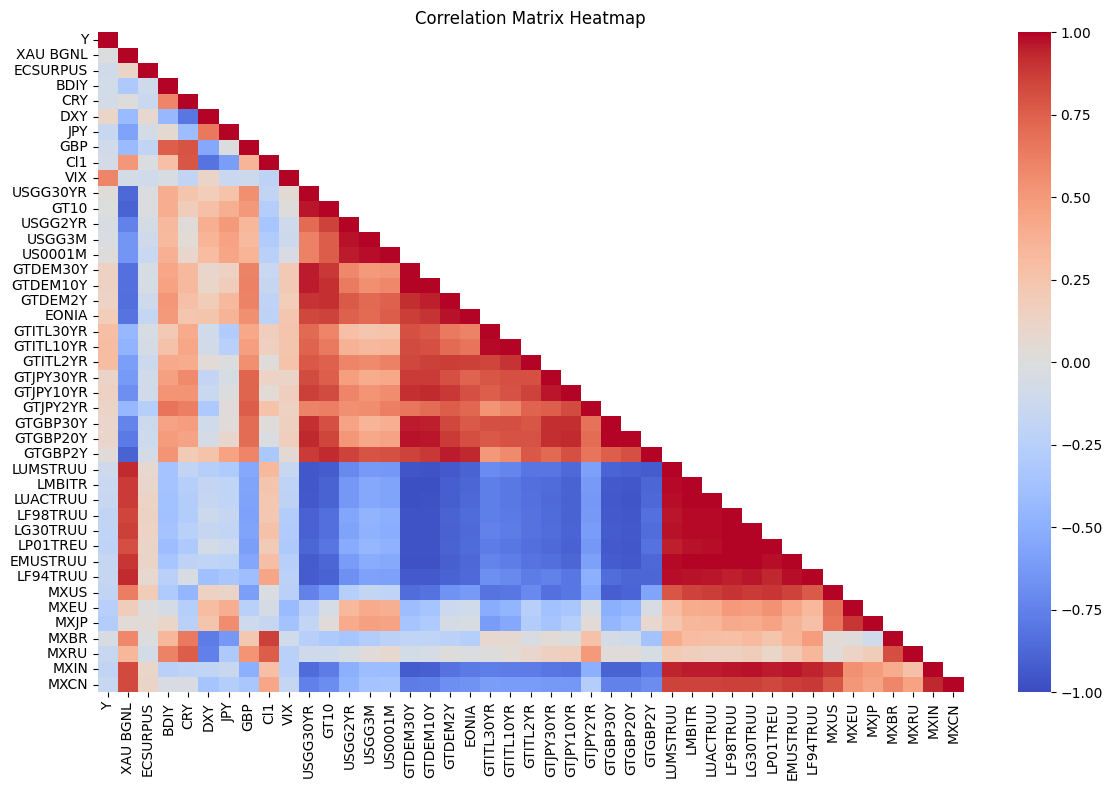

In [ ]:
# Plot correlation matrix
corr_matrix = numeric_df.corr()

# Get the upper triangle of the correlation matrix to avoid duplicates
upper_triangle = np.triu(corr_matrix)

# Create a mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix), k=1)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create heatmap using seaborn
sns.heatmap(corr_matrix,
            mask=mask,
            annot=False,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0)

plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
correlations = numeric_df.corr()['Y'].sort_values(ascending=False)
print("Top feature correlations with target")
print(correlations)

Top feature correlations with target
Y            1.000000
VIX          0.598432
GTITL2YR     0.304528
GTITL10YR    0.297573
GTITL30YR    0.295000
EONIA        0.180311
GTDEM30Y     0.141537
GTDEM10Y     0.139933
GTJPY10YR    0.133660
GTDEM2Y      0.130607
GTJPY30YR    0.114555
GTJPY2YR     0.112314
DXY          0.103227
GTGBP20Y     0.100142
GTGBP30Y     0.099777
GTGBP2Y      0.035010
USGG30YR     0.019255
US0001M      0.015379
GT10        -0.004776
XAU BGNL    -0.011535
USGG3M      -0.025935
USGG2YR     -0.034909
MXBR        -0.043429
Cl1         -0.070141
CRY         -0.074102
BDIY        -0.083440
ECSURPUS    -0.090772
GBP         -0.093201
LUMSTRUU    -0.104897
LMBITR      -0.143607
MXRU        -0.148848
MXCN        -0.149581
JPY         -0.151197
LUACTRUU    -0.153544
LF94TRUU    -0.156550
EMUSTRUU    -0.169475
MXIN        -0.188942
LF98TRUU    -0.189661
MXUS        -0.193928
LG30TRUU    -0.197232
LP01TREU    -0.209774
MXEU        -0.253877
MXJP        -0.279399
Name: Y, dtype: f

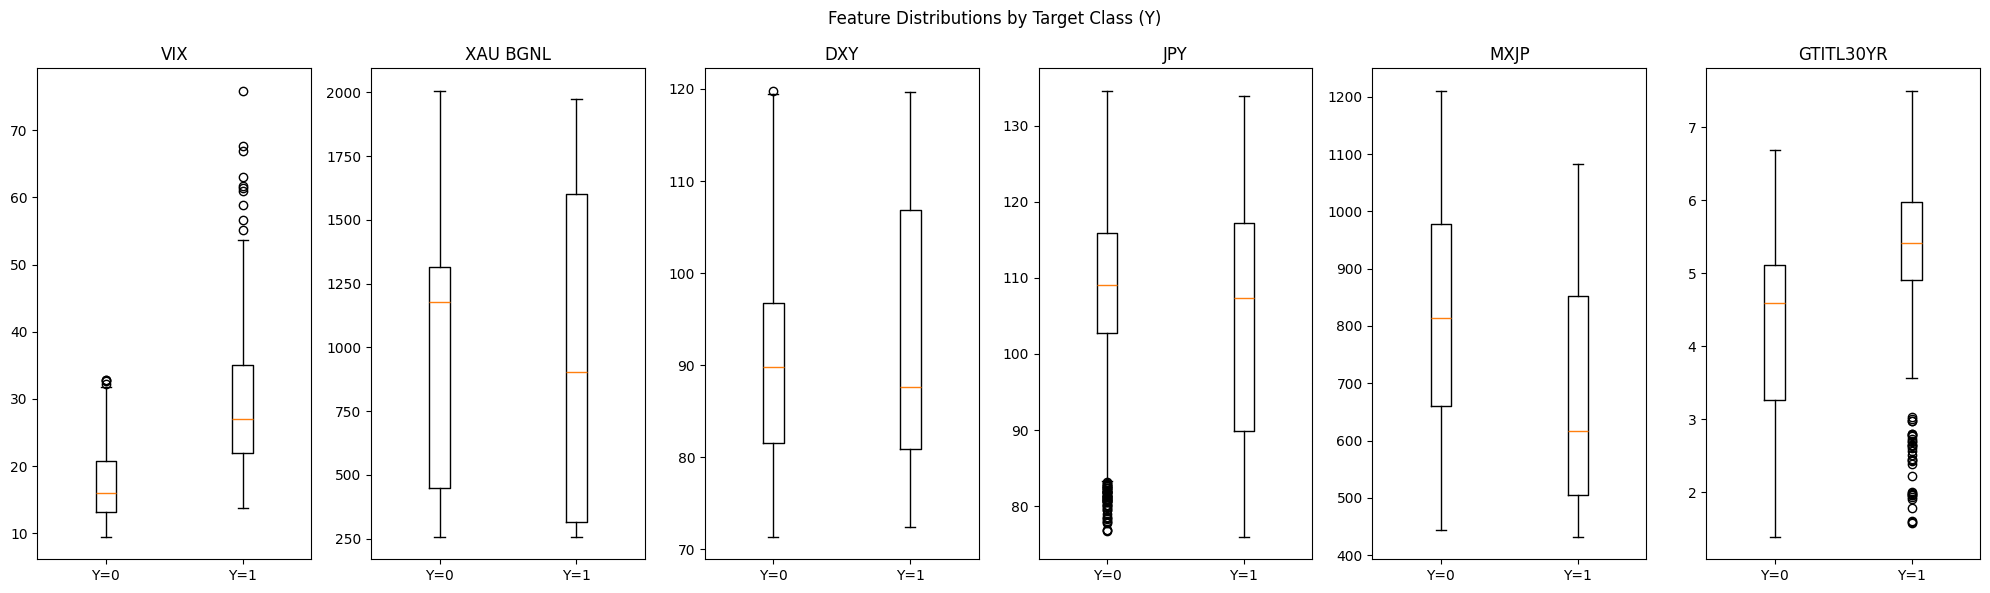

In [ ]:
# Select some relevant columns
cols_to_plot = ["VIX", "XAU BGNL", "DXY", "JPY", "MXJP", "GTITL30YR"]

# Create figures with subplots
fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(20, 6))
fig.suptitle('Feature Distributions by Target Class (Y)')

# Create boxplots
for i, col in enumerate(cols_to_plot):
  data = [df[df['Y'] == 0][col], df[df['Y'] == 1][col]]
  axes[i].boxplot(data, labels=['Y=0', 'Y=1'])
  axes[i].set_title(col)
  axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

<Figure size 2000x600 with 0 Axes>

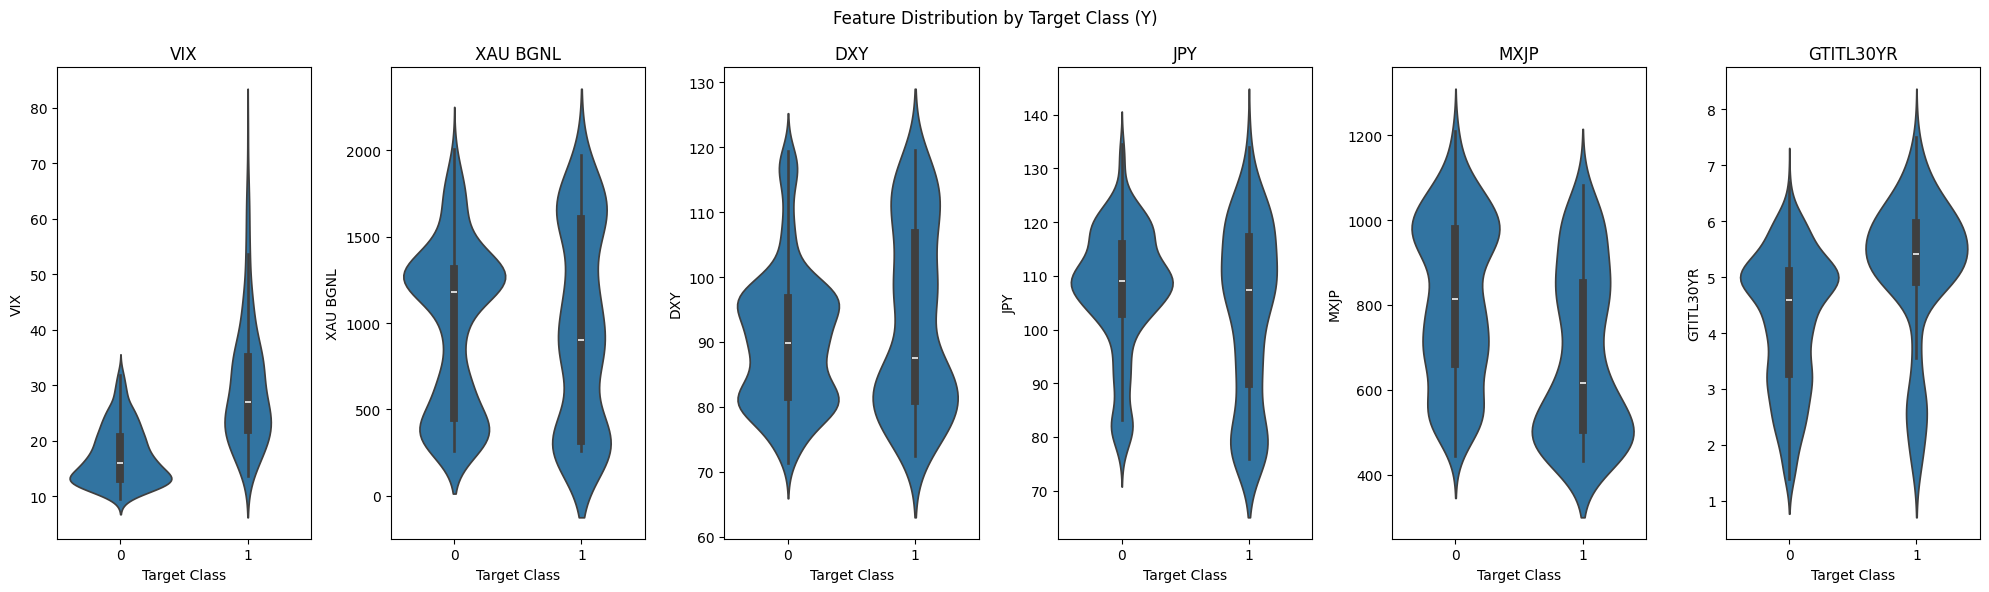

In [ ]:
# Create violin plots for feature distribution comparison
plt.figure(figsize=(20, 6))

# Create subplots
fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(20, 6))
fig.suptitle('Feature Distribution by Target Class (Y)')

# Create violin plots
for i, col in enumerate(cols_to_plot):
  sns.violinplot(
      data=df,
      x='Y',
      y=col,
      ax=axes[i],
      inner='box'
  )

  axes[i].set_title(col)
  axes[i].set_xlabel('Target Class')

plt.tight_layout()
plt.show()

<Figure size 2000x600 with 0 Axes>

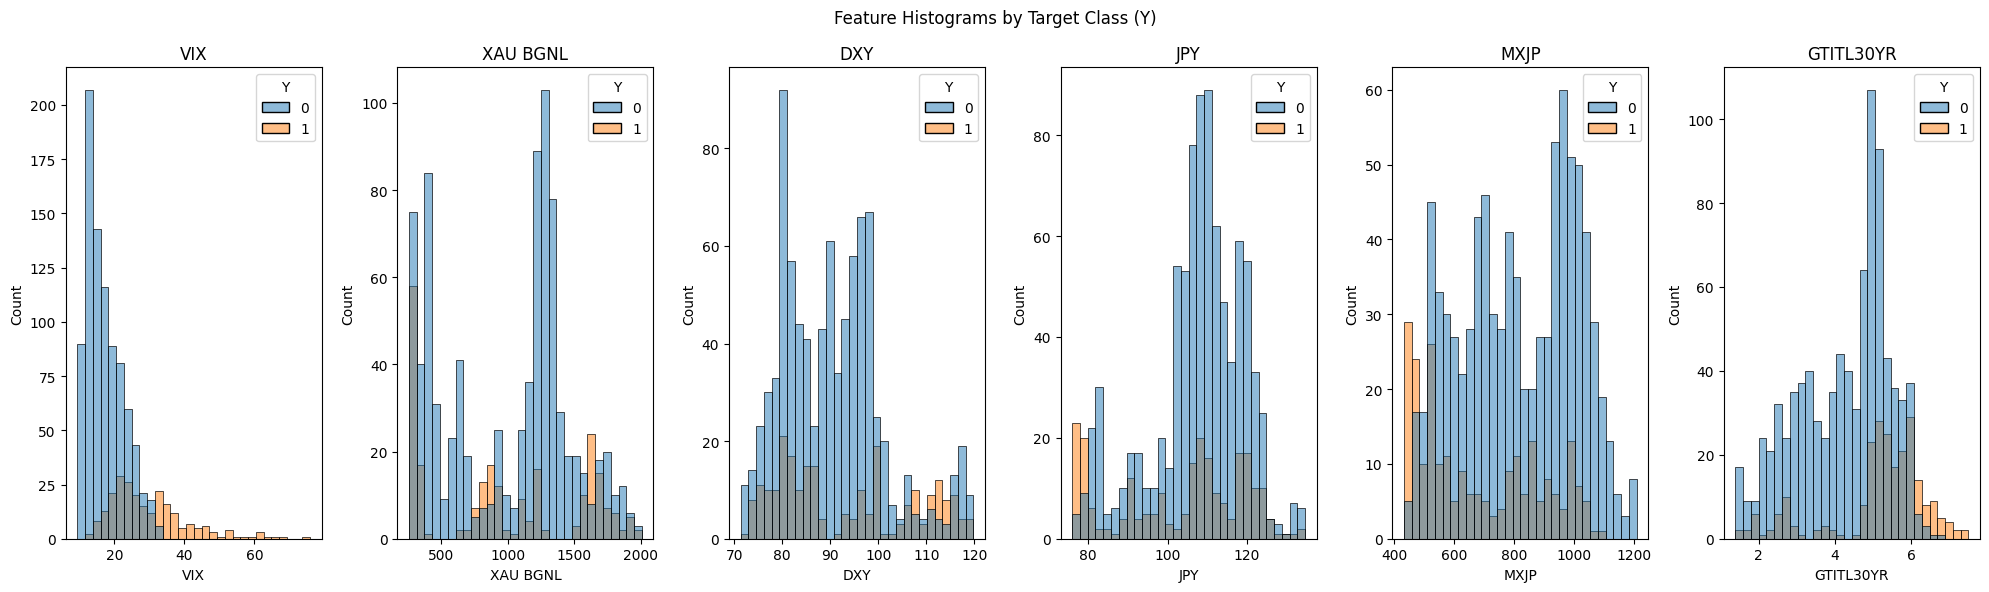

In [ ]:
# Create histogram plots
plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(20, 6))
fig.suptitle('Feature Histograms by Target Class (Y)')

for i, col in enumerate(cols_to_plot):
  sns.histplot(
      data=df,
      x=col,
      hue='Y',
      ax=axes[i],
      multiple="layer",
      alpha=0.5,
      bins=30
  )
  axes[i].set_title(col)

plt.tight_layout()
plt.show()

Data Splitting and Logistic Regression

In [ ]:
# Prepare features (X) and target (Y)
X = df[['VIX']]
y = df['Y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LogisticRegression(random_state=42, max_iter=2000, C=0.5, class_weight="balanced", solver="liblinear")
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print model coefficients
print("\nModel Coefficients:")
print(f"VIX coefficient: {model.coef_[0][0]:.4f}")
print(f"Intercept: {model.intercept_[0]:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       177
           1       0.51      0.76      0.61        46

    accuracy                           0.80       223
   macro avg       0.72      0.78      0.74       223
weighted avg       0.84      0.80      0.81       223


Model Coefficients:
VIX coefficient: 0.1970
Intercept: -4.3067


Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import numpy as np

# Prepare features (X)
X = df[['VIX']]

# Create and train the Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=1000,
    contamination="auto",
    random_state=42,
    n_jobs=-1
  )

# Fit the model on the data and predict
# predict() returns 1 for inliers, -1 for outliers
predictions = iso_forest.fit_predict(X)

# Convert predictions to binary format (0 for normal, 1 for anomaly)
y_pred = np.where(predictions == -1, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y, y_pred))

# Evaluate the anomaly scores
anomaly_scores = iso_forest.score_samples(X)
print("\nAnomaly Score Statistics:")
print(f"Mean score: {np.mean(anomaly_scores):.4f}")
print(f"Min score: {np.min(anomaly_scores):.4f}")
print(f"Max score: {np.max(anomaly_scores):.4f}")




Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       874
           1       0.56      0.49      0.52       237

    accuracy                           0.81      1111
   macro avg       0.71      0.69      0.70      1111
weighted avg       0.80      0.81      0.80      1111


Anomaly Score Statistics:
Mean score: -0.4751
Min score: -0.8199
Max score: -0.4352


In [ ]:
# Prepare features (X) and target (Y)
X = df[['VIX', 'DXY', 'GTDEM2Y', 'EONIA', 'GTITL30YR', 'GTJPY30YR', 'GTJPY2YR']]
y = df['Y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=0.10,
    class_weight="balanced",
    solver="lbfgs",
    n_jobs=-1
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print model coefficients
print("\nModel Coefficients:")
print(f"VIX coefficient: {model.coef_[0][0]:.4f}")
print(f"Intercept: {model.intercept_[0]:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       177
           1       0.51      0.83      0.63        46

    accuracy                           0.80       223
   macro avg       0.73      0.81      0.75       223
weighted avg       0.86      0.80      0.82       223


Model Coefficients:
VIX coefficient: 0.2353
Intercept: -8.9830


              precision    recall  f1-score   support

           0       0.88      0.97      0.92       177
           1       0.79      0.50      0.61        46

    accuracy                           0.87       223
   macro avg       0.84      0.73      0.77       223
weighted avg       0.86      0.87      0.86       223



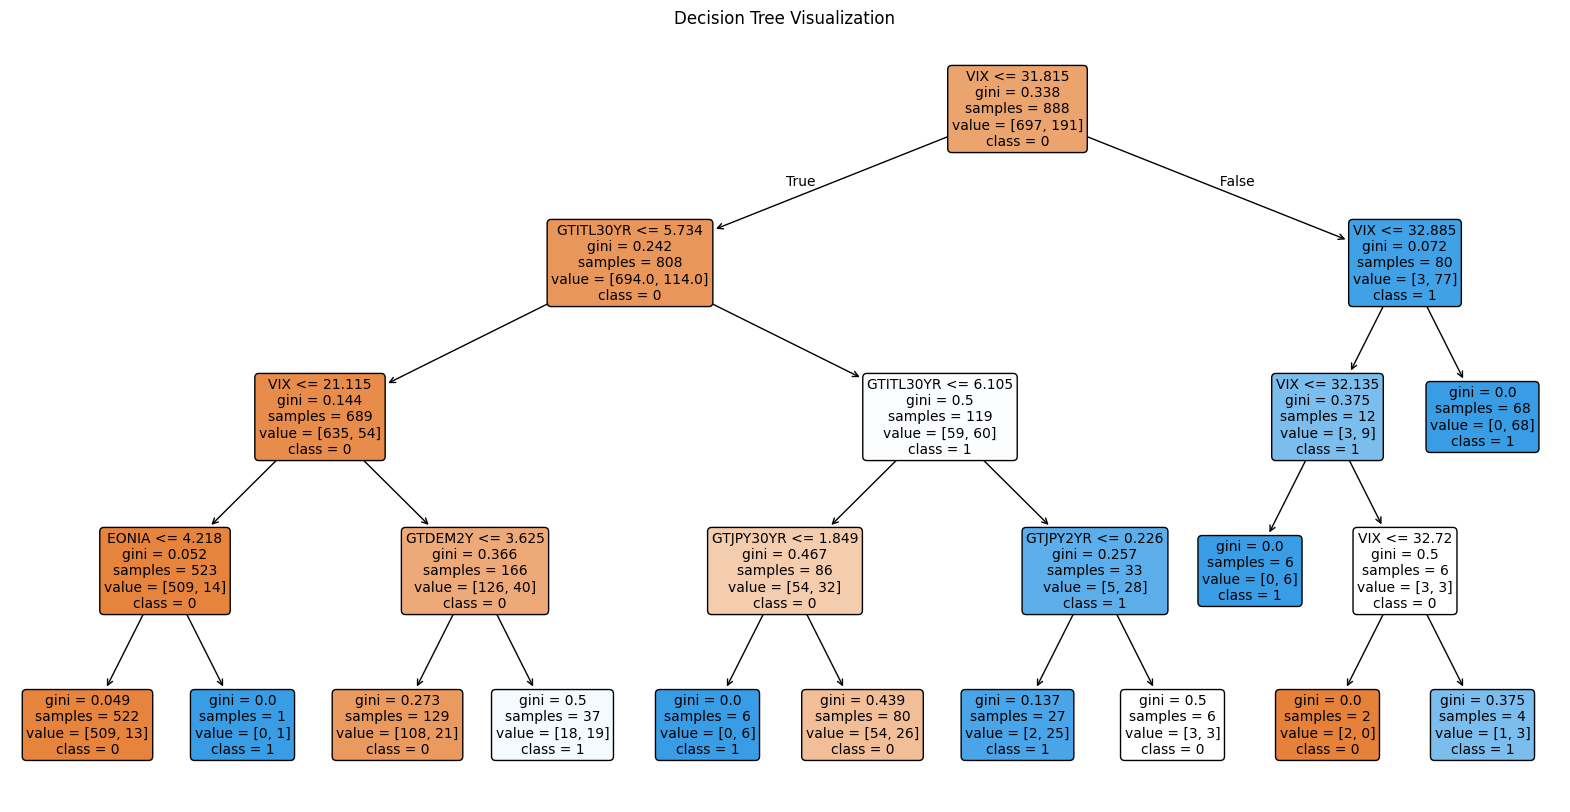

In [ ]:
# Visualize decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Create and train a decision tree classifier
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

print(classification_report(y_test, dt.predict(X_test)))

# Create figure with larger size for better visibility
plt.figure(figsize=(20, 10))

# Plot the decision tree
plot_tree(dt, feature_names=X.columns, class_names=['0', '1'],
          filled=True, rounded=True, fontsize=10)

plt.title("Decision Tree Visualization")
plt.show()

In [ ]:
# Scale features using StandardScaler
from sklearn.preprocessing import StandardScaler

X=df[['VIX', 'DXY']]
y=df['Y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    random_state=42,
    max_iter=2000,
    C=0.1,
    class_weight="balanced",
    solver='liblinear',
    n_jobs=-1
)

# Update model to use scaled data
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Print updated classification report with scaled data
print("Classification Report with Scaled Features:")
print(classification_report(y_test, y_pred))

# Print model coefficients with scaled features
print("\nModel Coefficients (Scaled Features):")
print(f"VIX coefficient: {model.coef_[0][0]:.4f}")
print(f"Intercept: {model.coef_[0][0]:.4f}")

Classification Report with Scaled Features:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       177
           1       0.51      0.76      0.61        46

    accuracy                           0.80       223
   macro avg       0.72      0.79      0.74       223
weighted avg       0.84      0.80      0.82       223


Model Coefficients (Scaled Features):
VIX coefficient: 1.7404
Intercept: 1.7404


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Streamlit App

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix



Overwriting app.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
streamlit run app.py

SyntaxError: invalid syntax (<ipython-input-23-718866ff34b9>, line 1)